In [6]:
import pandas as pd
import torch
import importlib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#%load_ext line_profiler

In [7]:
from model.eGauss_plus import eGAUSSp

ModuleNotFoundError: No module named 'model'

Client 1: {1: 11, 2: 12}
Client 2: {0: 26, 2: 11}
Client 3: {0: 9, 1: 25, 2: 11}
Test Set: {0: 15, 1: 14, 2: 16}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150


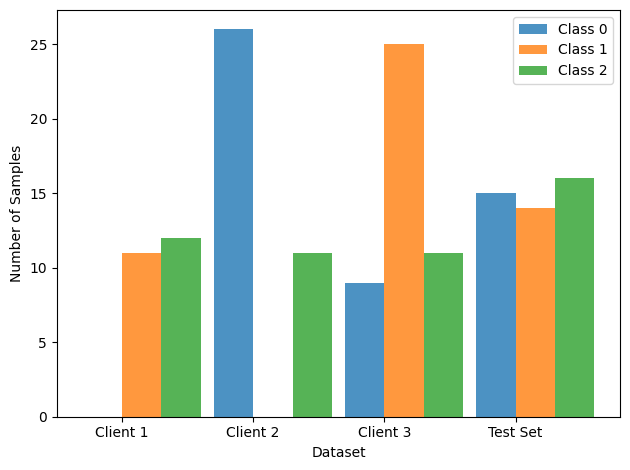

In [ ]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Scaling the 'Time' and 'Amount' features
#scaler = StandardScaler()
#X[:, [0, -1]] = scaler.fit_transform(X[:, [0, -1]])  # Assuming 'Time' is the first and 'Amount' is the last feature in the DataFrame

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create TensorDatasets for both training and testing data
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
test_dataset = TensorDataset(X_test, y_test.unsqueeze(1))

# Create DataLoaders for both datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

num_clients = 3
client_data, X_test, y_test, X_all, y_all = prepare_non_iid_dataset(X, y, num_clients)

display_dataset_split(client_data, y_test)
plot_dataset_split(client_data, y_test)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.utils import shuffle

# Define the number of clients dynamically
num_clients = 4  # or any other number

# Determine the total amount of data from the dataset
total_data = len(data)  # Total number of data points in the dataset

# Total number of fraud and non-fraud cases
total_frauds = sum(data['Class'] == 1)
total_non_frauds = total_data - total_frauds

# Generate dynamic data amounts for each client
data_amount = np.random.randint(10, total_data, num_clients)
data_amount = (data_amount / data_amount.sum()) * total_data  # Normalize to sum to total_data
data_amount = data_amount.astype(int)
data_amount[-1] = total_data - data_amount[:-1].sum()  # Adjust the last element

# Separate fraud and non-fraud indices
fraud_indices = data[data['Class'] == 1].index.tolist()
non_fraud_indices = data[data['Class'] == 0].index.tolist()

# Shuffle indices
np.random.shuffle(fraud_indices)
np.random.shuffle(non_fraud_indices)

# Partitioning data
partitions = {i: pd.DataFrame() for i in range(num_clients)}
fraud_counter = non_fraud_counter = 0

for i in range(num_clients):
    num_frauds_client = int((data_amount[i] / total_data) * total_frauds)
    num_non_frauds_client = data_amount[i] - num_frauds_client

    # Select indices for this client
    client_fraud_indices = fraud_indices[fraud_counter:fraud_counter + num_frauds_client]
    client_non_fraud_indices = non_fraud_indices[non_fraud_counter:non_fraud_counter + num_non_frauds_client]

    fraud_counter += num_frauds_client
    non_fraud_counter += num_non_frauds_client

    subset_indices = np.concatenate([client_fraud_indices, client_non_fraud_indices])
    subset_indices = shuffle(subset_indices, random_state=42)

    partitions[i] = data.loc[subset_indices]

# Convert partitions to PyTorch datasets
datasets = {}
for i in range(num_clients):
    features = torch.tensor(partitions[i].drop('Class', axis=1).values, dtype=torch.float32)
    labels = torch.tensor(partitions[i]['Class'].values, dtype=torch.int64)
    datasets[i] = TensorDataset(features, labels.unsqueeze(1))

# Initialize models for each client
local_models = {i: eGAUSSp(feature_dim=30, num_classes=2, N_max=30, num_sigma=2, kappa_join=1.5, S_0=1e-10, c_max=4, device=device) for i in range(num_clients)}

In [ ]:

import threading

def training_loop(dataloader, model, device, num_sigma, N_max):
    viewed_samples = []
    viewed_labels = []

    for idx, (point, label) in enumerate(dataloader):
        point, label = point.to(device).squeeze(0), label.to(device).squeeze(0)
        model(point, label)  # Assuming model(point, label) updates the model

        # Collect the viewed samples and labels
        viewed_samples.append(point.cpu())
        viewed_labels.append(label.cpu())

        if (idx + 1) % 100 == 0 or (idx + 1) == len(dataloader):
            print(f"** Processed {idx + 1} points. **")
            print(f"Number of clusters so far: {model.c}")

        if (idx + 1) % 10000 == 0 or (idx + 1) == len(dataloader):
            # Convert the collected samples and labels to a NumPy array
            samples_np = torch.vstack(viewed_samples).numpy()
            labels_np = torch.hstack(viewed_labels).numpy()

            # Plot the samples (assuming you have a defined function plot_pairwise_against_first_feature)
            plot_first_feature(data=samples_np, labels=labels_np, model=model, num_sigma=num_sigma, N_max=N_max)


def train_model_thread(datasets, local_model, device, num_sigma, N_max):
    print(f"Starting training for local model {i}")

    # Create a DataLoader for the local dataset
    local_dataloader = DataLoader(datasets, batch_size=1, shuffle=True)  # Adjust batch_size as needed

    # Run the training loop for the local model
    training_loop(local_dataloader, local_model, device, num_sigma, N_max)

    print(f"Finished training for local model {i}")

threads = []
for i, local_model in local_models.items():
    thread = threading.Thread(target=train_model_thread, args=(datasets[i], local_model, device, num_sigma, N_max))
    threads.append(thread)
    thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()
